# Introduction
This goal of this project is to explore two methods for calculating disparity maps from pairs of stereo images. The first method is a simple window-based search. The second method uses a graph structure and iterative energy minimization. Both of these methods will be tested against the same set of images, pulled from the Middlebury dataset.<sup>[1]</sup>

# Window-based Search
## Algorithm
The is method is rather simple. For each pixel in the left image `p`, we find the pixel `q` in the same row of the right that is "closest" to `p`. "Closest" here is defined by taking the sum of squared differences (SSD) of the gray values of the pixels in some window around `p` and `q`:<sup>[2]</sup>

$$s_{tx}(r, c) = \sum_{j = 0}^{tplRows-1} \sum_{i = 0}^{tplCols-1}\left [t(j,i) - x\left (r + j - \frac{tplRows}{2}, c + i - \frac{tplCols}{2}\right ) \right ]^2$$

The disparity of `p` is then defined to be the number of pixels between `p` and `q`, where `q` minimizes the above equation. Using a window results in fewer false matches as the neighborhood around the pixel is considered as well when determining similarity. For edge and corner cases, where the window centered on the pixel does not fit within the bounds of the image, only those parts of the window that fall within the image are considered. The implication of this is that pixels on the left edge of the left image cannot be assigned a very high disparity because the search range for such disparity values falls outside of the bounds of the image.

There are two parameters for tuning this algorithm. The first is search depth, or how far along the row the algorithm searches for a best match. Larger disparity values (big shits between left and right images) require larger search depths. The search depths used are listed in the table above. The second parameter is the size of the window or neighborhood over which SSD is calculated. The same window size of 7x7 was used for all images.

## Implementation
A simple algorithm calls for a simple implementation. After all, we want to get to the fun stuff, right? First, the left and right images are converted to grayscale. Then, for each disparity level `d` up to a user-configurable `search_depth`, the SSD metric is computed for each pixel in the left image (except for the first `d` columns, as noted above) using the right image shifted left by `d` pixels. The lowest SSD seen for each pixel is tracked throughout the search. Finally, the pixel is assigned the disparity that minimizes its SSD.

One implementation detail of potential interest is that I convolved using a uniform filter, padding with zeros to handle edges and corners, to efficiently calculate the SSD in the neighborhood around each pixel.

## Results

In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import os
import proj
import stereo as st

%matplotlib inline
%load_ext autoreload
%autoreload 2

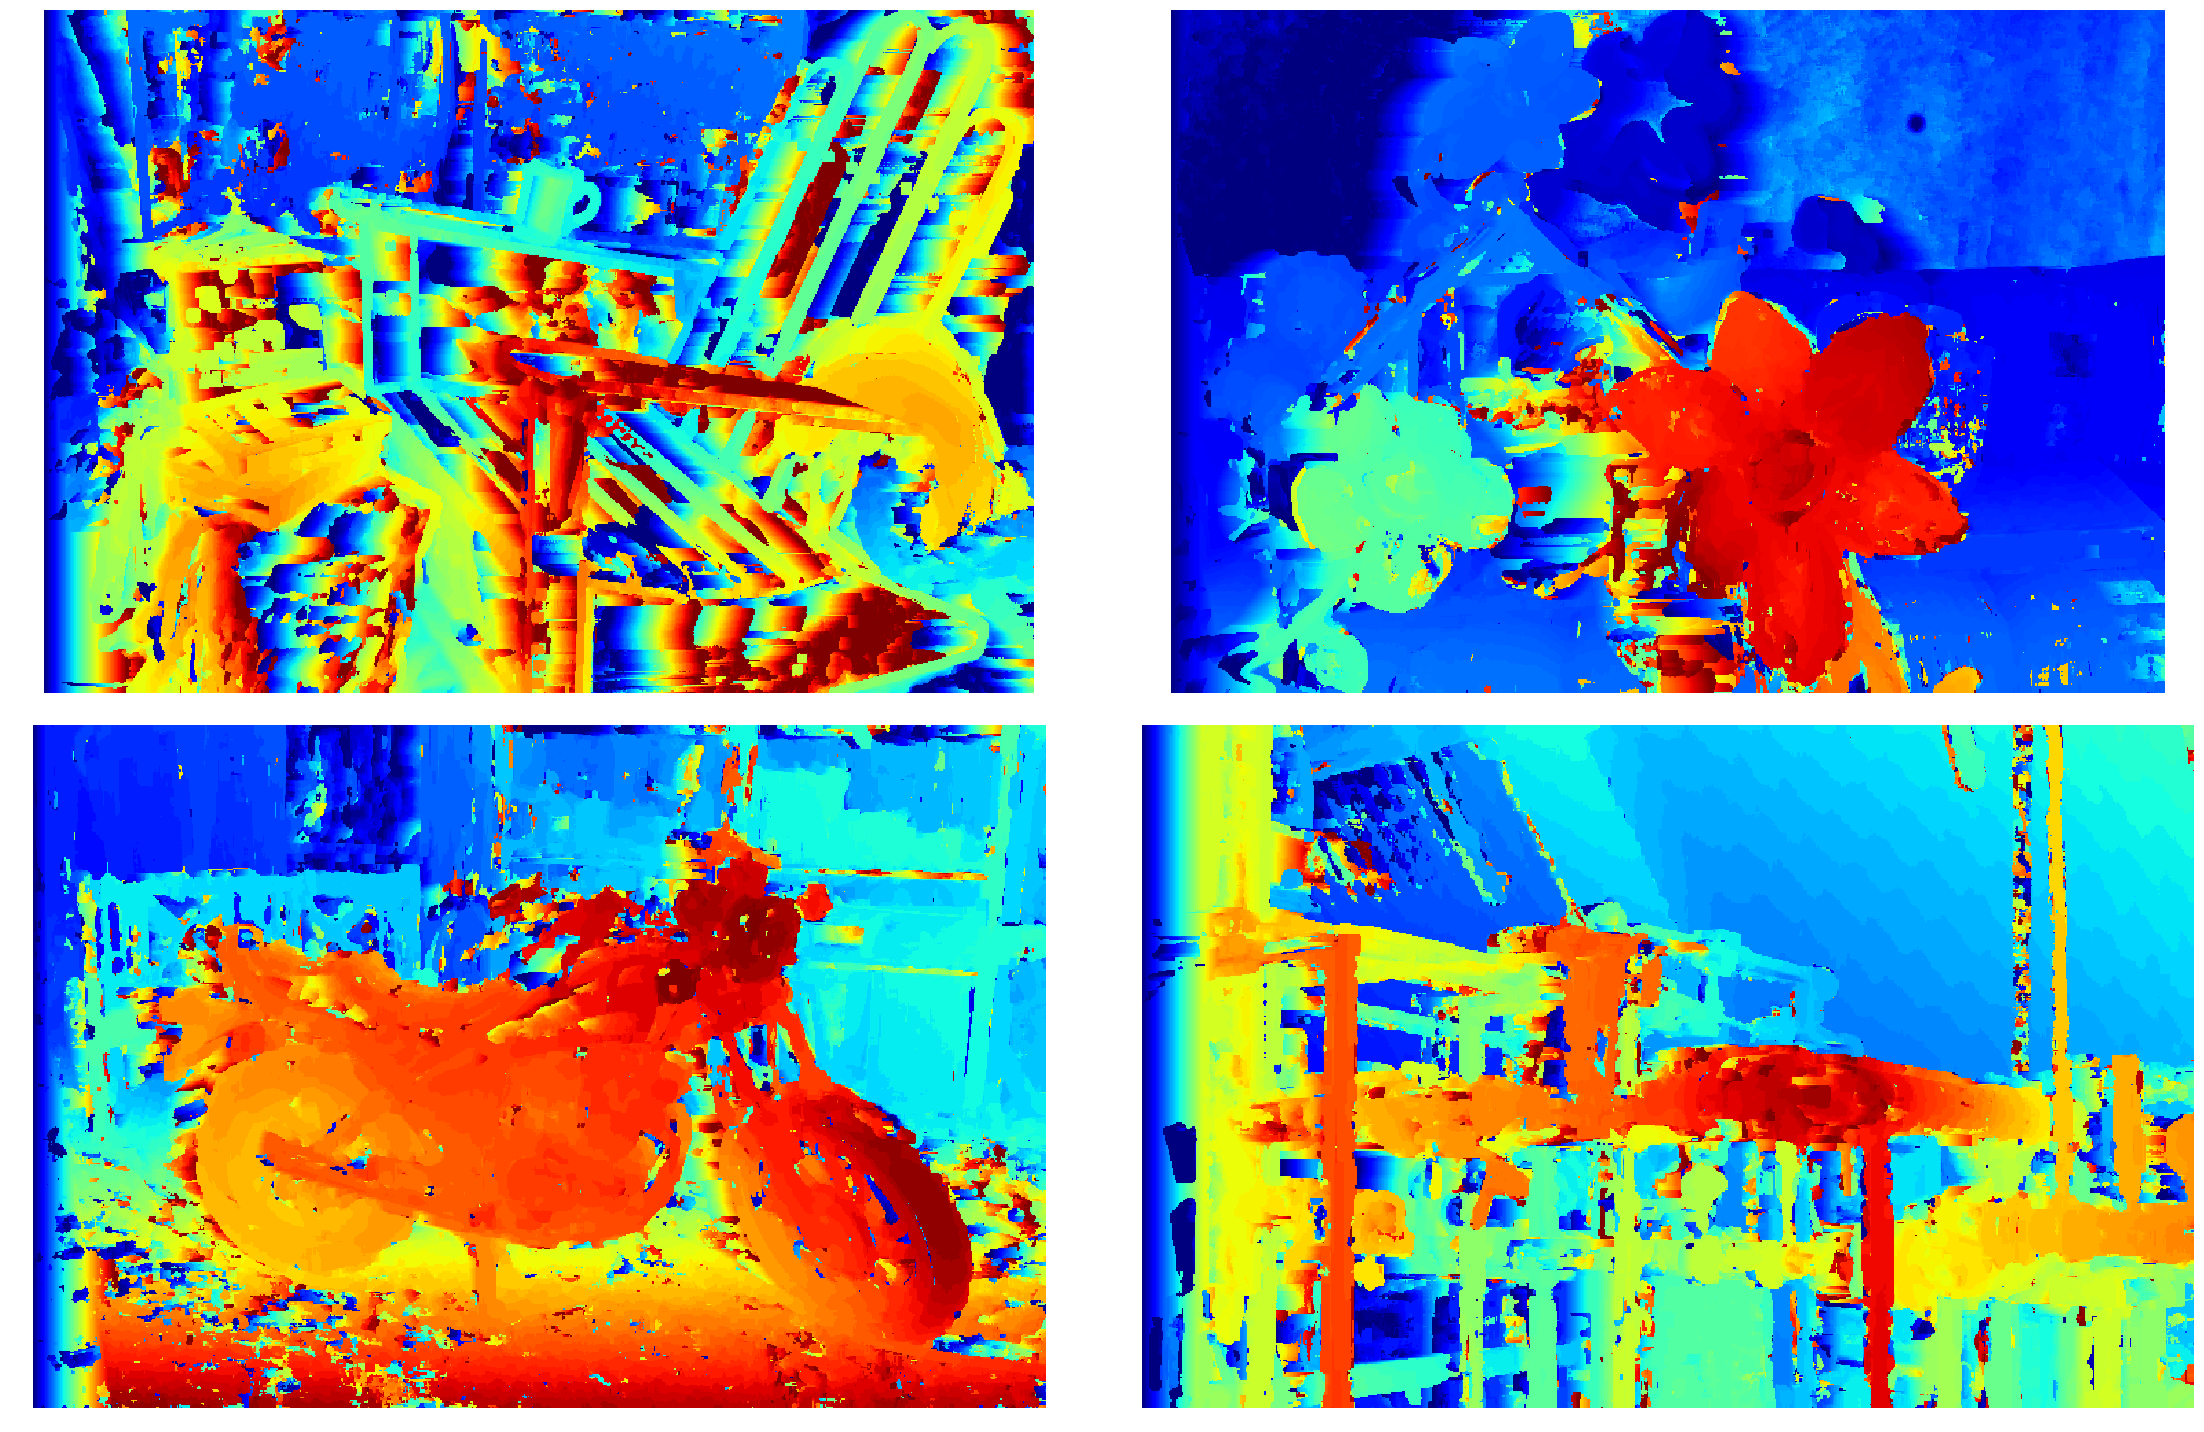

In [11]:
num_images = len(proj.REPORT_IMAGES) - 1
row_size = 2
fig, axarr = plt.subplots(math.ceil(num_images / row_size), row_size, figsize=(32,20))
i = 0
for image_pair in proj.REPORT_IMAGES:
    if image_pair == 'cones':
        continue
    disparity, _, _, _ = proj.process_image_pair(image_pair, generate_ssd=True)
    ax = axarr[i // row_size, i % row_size]
    ax.imshow(proj.disparity_to_jet(disparity, bgr=False))
    ax.axis('off')
    i += 1
    
plt.axis('off')
plt.tight_layout()
fig.show()

### Performance and Analysis
Not too shabby! Though each image is clearly recognizable, this simple method exhibits the classic problems of naive SSD methods. The first is streakiness or splotchiness, which is especially noticable in the images of the chair, flower, and the floor around the motorcycle. The disparity value for each pixel is calculated independently of its neighbors', and so the algorithm does not consider how well nearby pixels agree with each other. Another example of how the algorithm might use neighboring pixel information is to avoid mapping the more than one pixel in the left image to the same pixel in the right image. Finally, this method has no concept of occlusion, and so every pixel is assigned some disparity value even if it is occluded in one of the images.

Below is a comparison of the SSD-calculated disparities with the ground-truth values from the Middlebury dataset. Two accuracy measure are presented. The left value considers all pixels in the image, while the right considers only those pixels that are not occluded in the ground-truth. The calculated disparity is considered correct if it differs by two levels or less from ground truth.<sup>[3]</sup> The percentage of correct pixels are displayed in the table. The algorithm takes a while to run, so images and ground-truth values are scaled down by a factor of 4.

| Image      | Search depth | Accuracy    |
|------------|--------------|-------------|
| Adirondack | 50           | 24.2 / 24.8 |
| Flowers    | 120          | 31.5 / 33.1 |
| Motorcycle | 50           | 48.6 / 52.5 |
| Pipes      | 60           | 47.8 / 52.2 |

The motorcycle and pipes images perform especially well, which surprises me. I expected the complexity of the pipes image to be a major obstacle for this method. The method performs quite poorly on the image of the chair (adirondack). I suspect this is due to the periodic patttern of the slats leading to false matches.

# Graph Cuts
## Algorithm
Alright, the fun stuff! Now we're going to use Kolmogrov and Zabih's algorithm,<sup>[5]</sup> which is based on Boykov and Kolmogrov's work using graph cuts for image segmentation.<sup>[4]</sup> In contrast to the SSD method, which is hyper-local and treats each pixel individually, this method uses local and global constraints to optimize the disparity assignments across the entire image. It does this by considering the problem one of energy minimization, where the energy term is composed of four parts:
* $E_{data}$ represents how well a pixel's assigned disparity value agrees with the data (the left and right images). For this project, I used the square difference of gray values. The lower the energy, the better the agreement between left image, right image, and disparity value.
* $E_{occlusion}$ allows for the possibility of assigning a pixel _no_ disparity value, in which case it is considered "occluded." The algorithm is weighted in favor of minimizing the number of occluded pixels by assigning a cost to each one, which is what this term represents.
* $E_{smoothness}$ addresses the streaks and splotches we saw with naive SSD. When two pixels are adjacent and have similar gray values in both the left and right image, this term is high when they are assigned different disparity values and low when they are assigned the same disparity value. Therefore, the algorithm prefers to assign them the same disparity value.
* $E_{uniqueness}$ addresses the problem of multiple pixels in the left image being mapped to the same pixel in the right image. The value is _infinite_ when such a mapping occurs, and zero otherwise.

These terms are gone over in much more detail in [5]. The problem of minimizing the total energy is posed as one of minimizing cuts of a graph. This is done iteratively for each possible disparity value, expanding the number of pixels to which that disparity is assigned until a minimum is reached. In more detail, for each possible disparity value $\alpha$, we construct a graph where:
* There are two "terminal" nodes to which every other node is connected.
* Every other node in the graph is an assignment of a disparity value to a pixel. There are two such types of nodes:
  * "Label nodes" are assignments with the disparity value currently being expanded. These represent opportunities to expand $\alpha$ to include the pixel in question
  * "Active nodes" are active assignments with disparity values other than the one currently being expanded. After expansion, pixels in such assignments might be considered occluded.
* Edges between nodes represent the energy terms discussed above. Specifically:
  * $E_{data}$, $E_{occlusion}$, $E_{smoothness}$ appear in the edges between terminal and non-terminal nodes
  * $E_{smoothness}$ and $E_{uniqueness}$ appear in the edges between non-terminal nodes

A cut of such a graph is a collection of edges that, if removed, would partition the graph into two disconnected sub-graphs. The cost of such a cut is the sum of the weights of all the edges. Since both terminal nodes are initially connected to every other node ("terminal edges"), partitioning the graph requires cutting one of the terminal edges for each non-terminal node. If a cut in question has the mimimum cost, it minimizes the above energy, and so the terminal edge which is included in the cut (_removed_ from the graph) represents the new assignment of the pixel. The algorithm proceeds by considering each possible disparity, in random order, in a series of expansion-only steps until a maximum number of iterations is reached or no assignment is expanded during the iteration. Of course, significantly more detail is included in [5].

The parameters to tune in the algorithm are the search depth $dMax$ (same as above), occlusion cost $K$ (how heavily occluded pixels are penalized), smoothness cost (how much is smoothness preferred), smoothness threshold (maximum similarity for neighboring pixels to incur a smoothness penalty for differing disparities), whether or not the order of label expansions is randomized for each iteration, and the maximum number of iterations.

## Implementation

This project's implementation is heavily influenced by KZ2.<sup>[6]</sup> However, considering that [6] is written in C++ and this project uses Python, significant performance improvements were necessary. Even so, it is worth noting that this project's impmlementation currently takes 2-3 hours on an 8th generation i7 laptop to compute the disparities for the images included in this report. Some of these improvements incude:

* All pairs of neighboring pixels in the image are computed once on initializtion and reused in each expansion step (fun with numpy broadcasting!).
* Calculating the smoothness weight between neighboring pixels involves calculating the difference between their gray values in the left image and the gray values of their assigned pixels in the right image. While the latter value can change as the pixels' assignments change, the former is constant throughout. As such, it is pre-computed, compared to the necessary threshold, and the result is stored for re-use.
* All operations are vectorized that did not involve the setting of edge weights in the graph. The library used for constructing the graph, PyMaxflow, does not have an interface for adding terminal edges in bulk, and its interface for adding non-terminal edges in bulk requires a grid structure that I'm not sure holds in the case of this project (more on this in the improvements section).
* In addition to specifying a search depth, the user can also specify a granularity of search. For example, for a search depth of 150, rather than considering all 150 possible disparities the user can choose to limit the search to every third disparity level (0, 3, 6, 9, etc.).

## Results

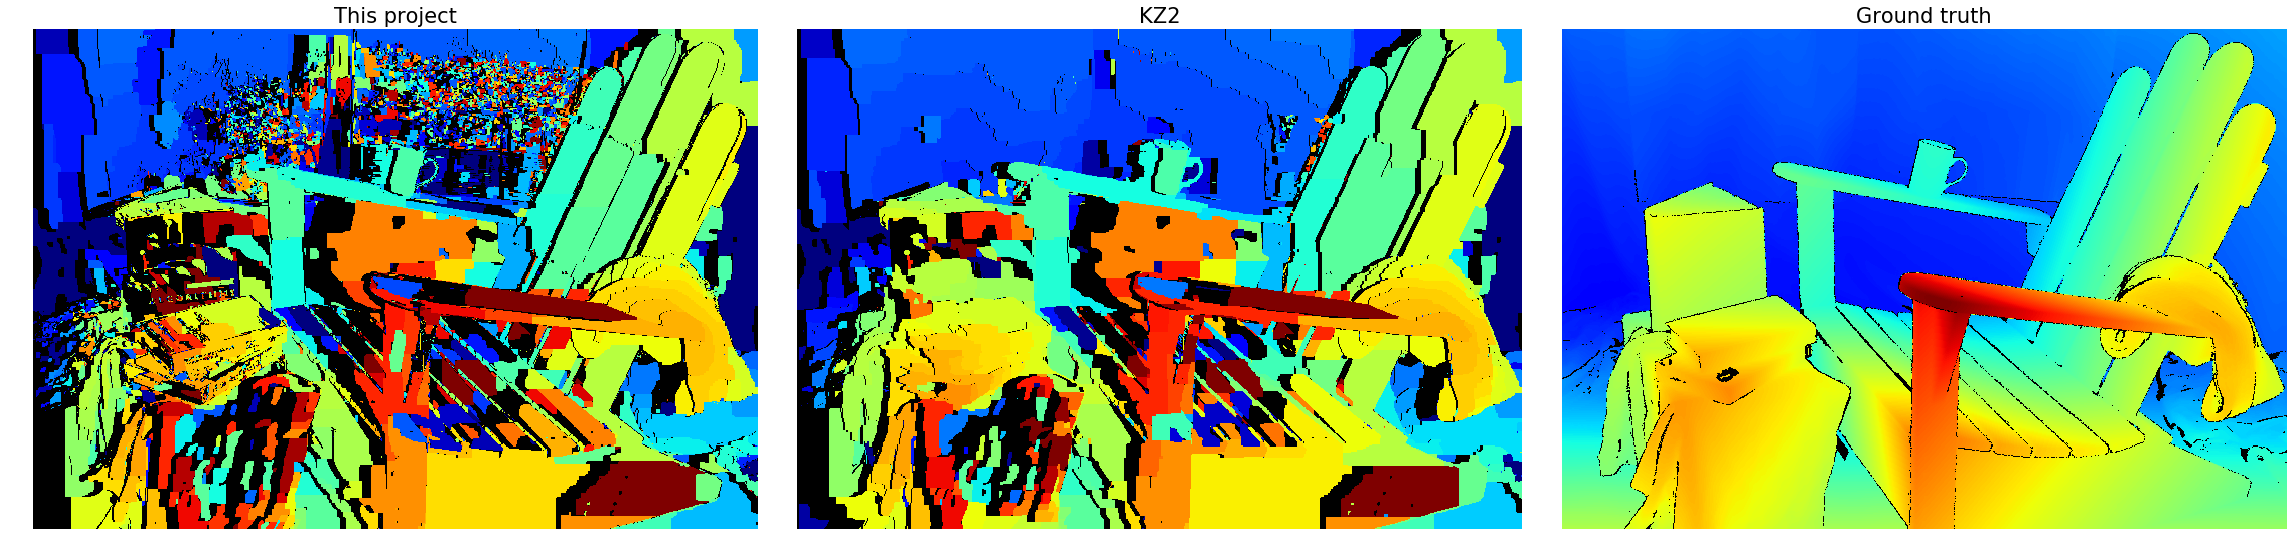

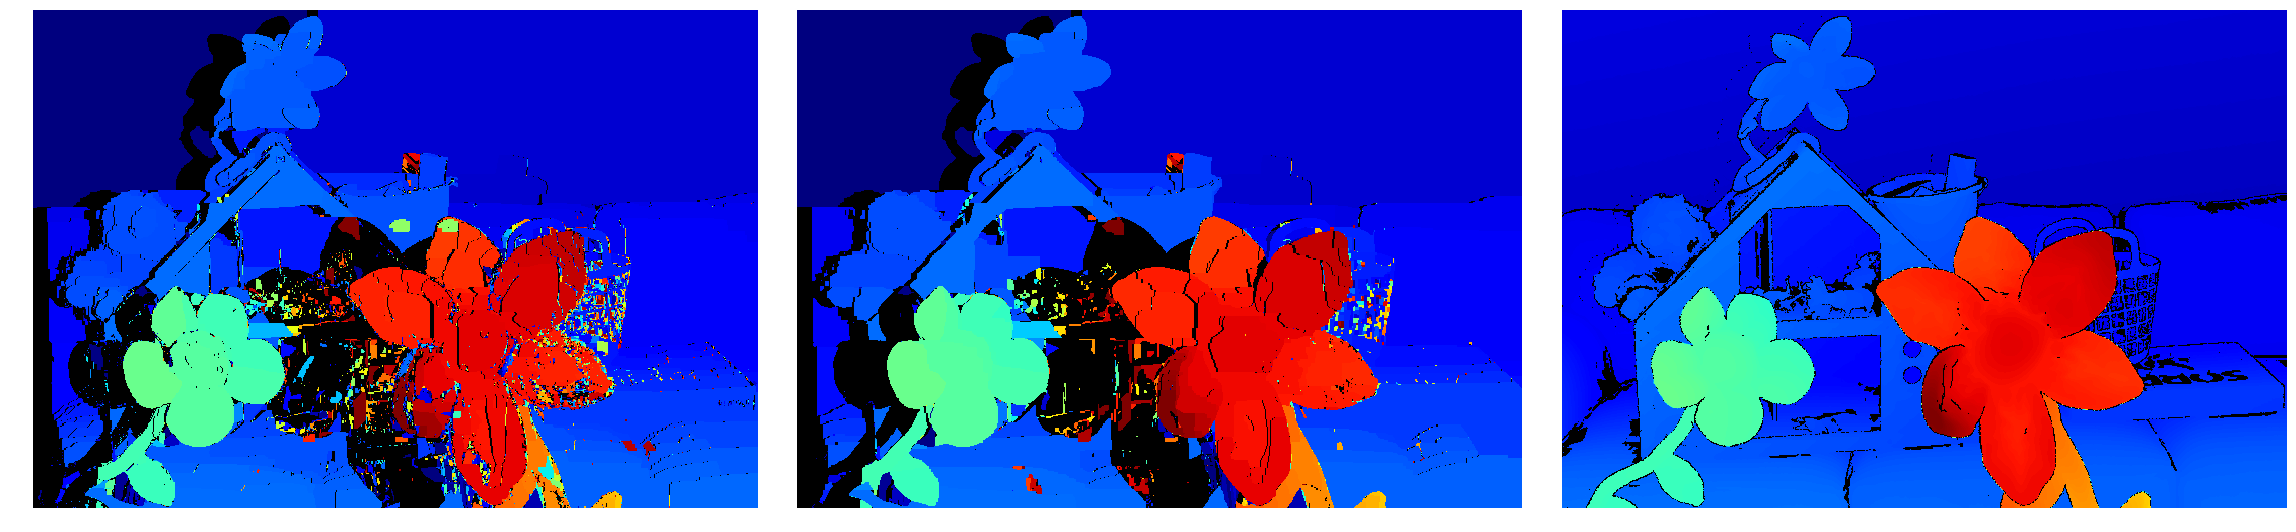

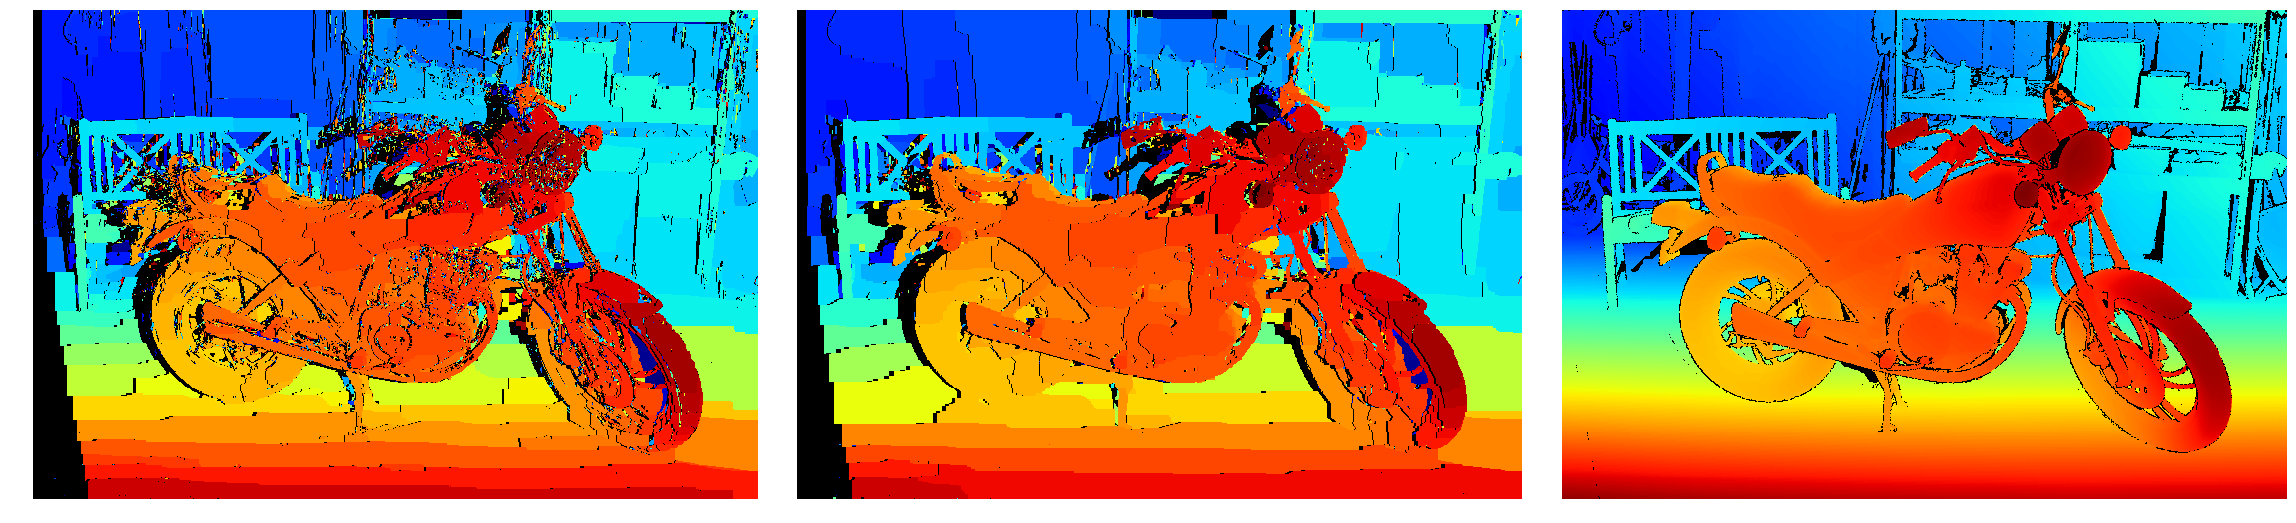

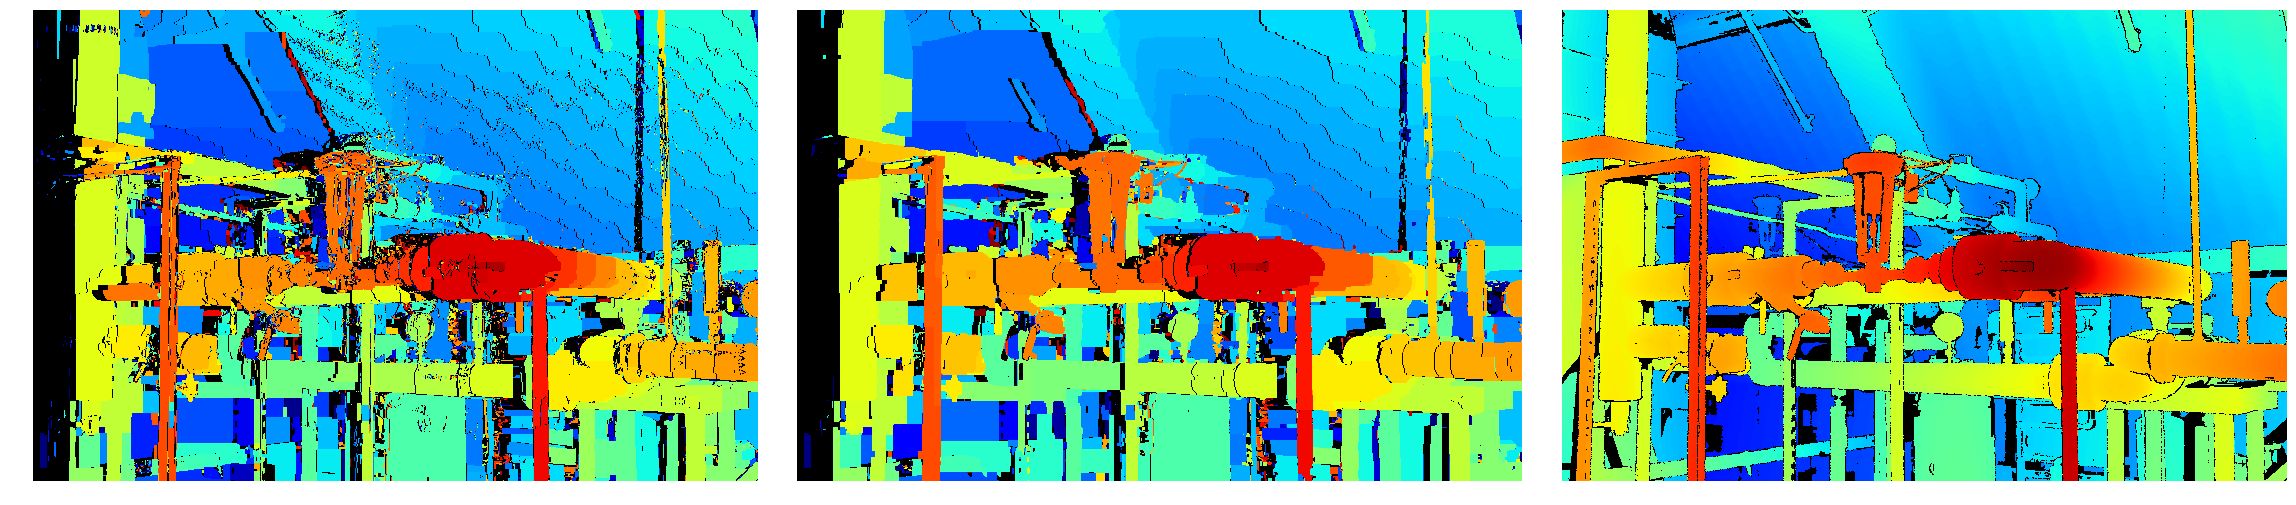

In [10]:
include_title = True
for image_pair in proj.REPORT_IMAGES:
    pfm_scale = proj.REPORT_IMAGES[image_pair][2]
    if pfm_scale is None:
        continue
    
    fig, axarr = plt.subplots(1, 3, figsize=(32,8))
    graphcut = cv2.imread(os.path.join(proj.OUTPUT_DIR, image_pair, 'graphcut-jet.png'))
    kz2 = proj.load_pfm(os.path.join(proj.OUTPUT_DIR, image_pair, 'kz2.pfm'))
    ground_truth = proj.load_pfm(os.path.join(proj.INPUT_DIR, image_pair, 'disp0.pfm'), pfm_scale)
    
    axarr[0].imshow(cv2.cvtColor(graphcut, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(proj.disparity_to_jet(kz2, bgr=False))
    axarr[2].imshow(proj.disparity_to_jet(ground_truth, bgr=False))
    for i in range(3):
        axarr[i].axis('off')
    
    if include_title:
        title_options = { 'fontsize': 21 }
        axarr[0].set_title('This project', title_options)
        axarr[1].set_title('KZ2', title_options)
        axarr[2].set_title('Ground truth', title_options)
        include_title = False
    
    plt.axis('off')
    plt.tight_layout()
    fig.show()

### Performance and Analysis
Most striking to me is the higher number of occluded pixels in the project's implementation. This could probably be resolved by tweaking $K$. However, consider the terrible performance of this project's implementation on Adirondack. The splotchy area above the chair is where two maps are hanging on the wall in the original images. It seems most likely that this is either due to a smoothness cost that is too low or the distance metric being used by this project. This project used a simple squared difference to calculate $E_{data}$, whereas KZ2 uses a distance metric from Birchfield and Thomasi with local effects.<sup>[7]</sup>

Now, consider the following performance metrics:

| Image      | K   | dMax | Project Accuracy | KZ2 Accuracy |
|------------|-----|------|------------------|--------------|
| Adirondack | 80  | 50   | 16.7 / 16.3      | 30.3 / 30.6  |
| Flowers    | 203 | 120  | 41.1 / 41.6      | 38.8 / 39.4  |
| Motorcycle | 118 | 50   | 46.5 / 48        | 44.4 / 46.7  |
| Pipes      | 82  | 60   | 51.9 / 54.1      | 47.0 / 49.9  |

How about that?! This project's implementation _outperformed_ KZ2 on three of the four images! That is definitely unexpected. However, it's also worth noting that this project's implementation takes orders of magnitude longer to run. For comparison, other high-ranking algorithms for the Middlebury dataset that mention energy minimization or graph cuts fare in the 60-65% accuracy range, which is around 60% higher accuracy than this project. The best of the best achieve greater than 90% accuracy, with the current leaderboard champion sitting at 94.99% average accuracy.<sup>[8]</sup> This leading implementation, which was developed for autonomous vehicles, decomposes a scene into independent objects and "superpixels" (piecewise planar sections of the image), each with its own rigid motion model. These planar surfaces are used to constrain the possible disparity values, like the smoothness energy in this project's algorithm.

# Future Improvements
In the interest of performance, it would be worthwhile to investigate if the PyMaxflow API allows for vectorized setting of edge weights. The slowest part of this project's implementation is the addition of smoothness weights, which (not coincidentally, I'm sure) is also the code base's largest for loop.

It also might be interesting to explore automatic parameter tuning. KZ2 implements auto-tuning for the occlusion and smoothness costs, but itt would also be useful to automatically discover the appropriate search depth. Perhaps performance could even be further improved by assymetrically pruning disparity levels that consistently fail to expand. In other words, in each iteration, we remove from consideration those disparity levels which failed to expand in the previous X iterations.

I also wonder if the simple squared-difference metric might not be improved by one that considers the value of neighboring pixels as well. We need to be careful here, as the expansion strategy employed here only holds if the data energy is a true metric.<sup>[8]</sup>

# References
1. D. Scharstein, H. Hirschmüller, Y. Kitajima, G. Krathwohl, N. Nesic, X. Wang, and P. Westling. High-resolution stereo datasets with subpixel-accurate ground truth. In German Conference on Pattern Recognition (GCPR 2014), Münster, Germany, September 2014.
2. Image Proximity Measures. (2018). Retrieved from https://software.intel.com/en-us/node/504333
3. Middlebury Stereo Evaluation - Version 3 - new features. (2018). Retrieved from http://vision.middlebury.edu/stereo/eval3/MiddEval3-newFeatures.html
4. Boykov, Y., & Kolmogorov, V. (2004). An Experimental Comparison of Min-cut/Max-flow Algorithms for Energy Minimization in Vision. _IEEE Transactions on Pattern Analysis and Machine Intelligence_, 26(9), 1124-1137. doi:10.1109/TPAMI.2004.60
5. Kolmogorov, V., Monasse, P., & Tan, P. (2014). Kolmogorov and Zabih’s Graph Cuts Stereo Matching Algorithm. _Image Processing On Line_, 4, 220-251. doi:10.5201/ipol.2014.97
6. Kolmogorov, V., & Monasse, P. (2017). Kolmogorov and Zabih’s graph cuts stereo matching algorithm. https://github.com/pmonasse/disparity-with-graph-cuts.
7. Birchfield, S., & Tomasi, C. (1999). Depth discontinuities by pixel-to-pixel stereo. _International Journal of Computer Vision_, 35(3), 269-293.
8. Anonymous. Superpixel alpha-expansion and normal adjustment for stereo matching. ECCV 2018 submission 500.
9. Boykov, Y., Veksler, O., & Zabih, R. (2001). Fast approximate energy minimization via graph cuts. _IEEE Transactions on pattern analysis and machine intelligence_, 23(11), 1222-1239.